# 16 Land cover statistics

## About the data

In this lesson we will use two datasets.

The first one is [GAP/LANDFIRE National Terrestrial Ecosystems data for 2011 @davidson_gaplandfire_2016](https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5), from the [US Geological Survey (USGS)](https://www.usgs.gov). This is a categorical raster with a 30 m x 30 m pixel resolution representing highly thematically detailed land cover map of the U.S. We will access this data through the [Microsoft Planetary Computer (MPC) data catalog](https://planetarycomputer.microsoft.com/dataset/gap). The class names and corresponding codes have been saved to a separete CSV to simplify access in this lesson. Further information on how to access the classes directly from the data are available in the [MPC catalog](https://planetarycomputer.microsoft.com/dataset/gap#Example-Notebook).


The second dataset is a shapefile with the perimeters for 2017 California fires. This data was extracted from the CALFIRE's [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/about).

## Import auxiliary geometries

Let's start by importing the necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Then import and select the Thomas Fire within the fire perimeters data:

<Axes: >

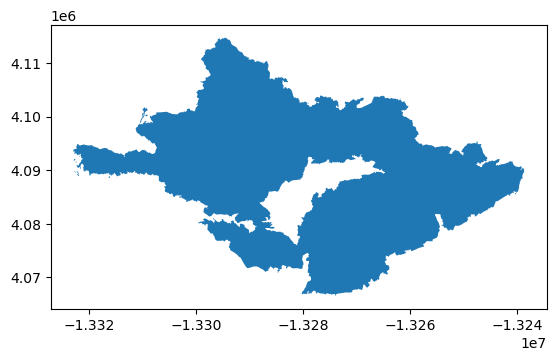

In [3]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA

fire_perimeters = gpd.read_file(os.path.join('data',
                  'California_Fire_Perimeters_2017',
                  'California_Fire_Perimeters_2017.shp'
                 ))
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']

# Examine fire perimeter data
thomas_fire.crs
thomas_fire.plot()

And import the CA state perimeter:

<Axes: >

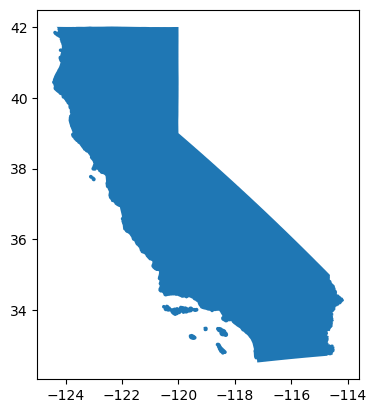

In [4]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA
ca = gpd.read_file(os.path.join('data',
                                'ca_state_boundary',   
                                'ca_state_boundary.shp'))
ca.plot()

And import the lables for the GAP Terrestrial Ecosystems Data:

In [5]:
# UPDATE THIS AS NEEDED SO YOU CAN IMPORT THE DATA
labels = pd.read_csv(os.path.join('data',
                                  'GAP_National_Terrestrial_Ecosystems.csv')
                                  )
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


## Catalog search

Our goal is to retrieve the National Terrestrial Ecosystems data over the fire perimeter. In the [last lesson](/book/chapters/lesson-16-STAC.qmd) we used GeoJSON-type dictionary to do the catalog search. Here we will use a list `[xmin, ymin, xmax, ymax]` with the coordinate values defining the four corners of the region we want to search data over. Just as the GeoJSON, these coordinates have to be in the EPSG:4326 CRS. 

Our bounding box will come from the Thomas Fire perimeter. Notice we use method chaining to reproject and extract the bounds.

In [9]:
# Create bounding box for search
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326').total_bounds)
thomas_fire_bbox

[-119.68162520650904,
 34.27989979600195,
 -118.92518097019486,
 34.63745683414112]

Next, we connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for the National Terrestrial Ecosystems data is `gap`:

In [11]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC datalog
search = catalog.search(collections=['gap'],
                        bbox=thomas_fire_bbox)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} length")
items

Returned 1 length


In [14]:
# Select unique search item
item = items[0]

# Display pre-rendered image
item.assets['rendered_preview'].href

Image(url = item.assets['rendered_preview'].href)

In [15]:
# Access raster data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)
lulc

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Notice that `band` is dimension of length 1. We can go ahead and "squeeze" the raster to simpligy it:

In [16]:
# Remove length 1 dimension (band)
lulc = lulc.squeeze().drop_vars('band')
print("Size of dimensions: ", dict(lulc.sizes))

Size of dimensions:  {'y': 10000, 'x': 10000}


Look at how this raster is located with respect to the Thomas Fire perimeter and the CA state boundary.

In [17]:
lulc.rio.bounds()

(-2361135.0, 1462215.0, -2061135.0, 1762215.0)

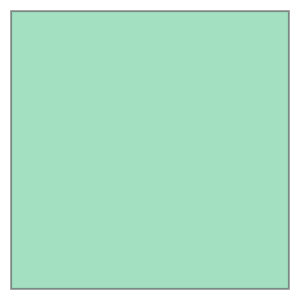

In [19]:
box(*lulc.rio.bounds())

In [21]:
# Create GeoDataFrame from raster bounding box
lulc_bbox = gpd.GeoDataFrame(geometry = [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)

lulc_bbox

,geometry
0,"POLYGON ((-2061135.000 1462215.000, -2061135.0..."


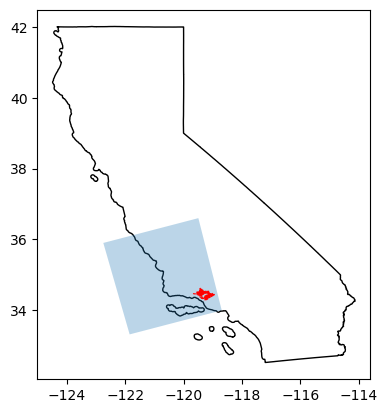

In [22]:
# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()

ca.plot(ax=ax, color = 'white', edgecolor = 'black')

# Reproject all other data to match CA crs
lulc_bbox.to_crs(ca.crs).plot(ax=ax, alpha = 0.3)
thomas_fire.to_crs(ca.crs).plot(ax = ax, color = 'red')

plt.show()

## Clio raster geometry

2-step clipping:

1. Clip the raster using the fire perimeter bounding box using `rio.clip_box()`
2. Clip the simplified raster to the fire perimeter using `rio.clip()`

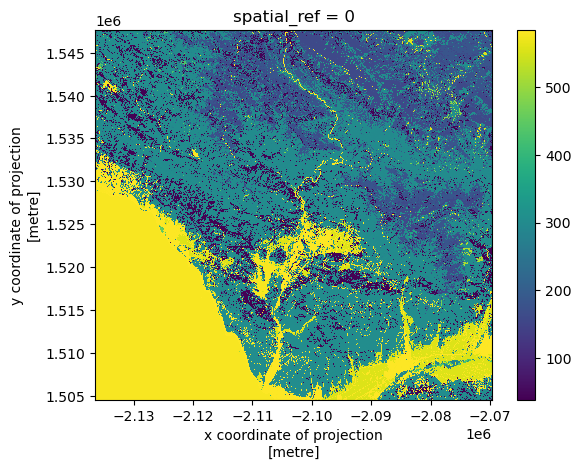

In [33]:
# Match CRSs and verify update
thomas_fire_match = thomas_fire.to_crs(lulc.rio.crs)
assert thomas_fire_match.crs == lulc.rio.crs

# Clip large raster to detailed geometry in two steps
lulc_step1 = lulc.rio.clip_box(*thomas_fire_match.total_bounds)
lulc_step1.plot()

In [30]:
thomas_fire_match.total_bounds

array([-2136456.73317806,  1504592.87928014, -2069636.48312869,
        1547634.13602822])

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


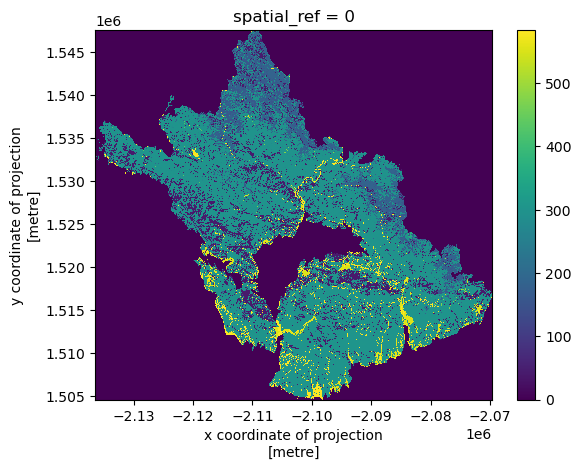

In [35]:
lulc_step2 = lulc_step1.rio.clip(thomas_fire_match.geometry)
lulc_step2.plot()

## Raster no-data values
`rio.clip()` function tries to replace values outside the fire perimeter with `np.nan` (a float!) but the raster's data type is `unit16`. The cast issue appears since `np.nan` cannot be casted as a `unit16`.

To make sure the clipping function fills in any pixels with the adequate no-data value. Let's manually set it.

In [37]:
print('Original no-data value: ', lulc.rio.nodata)

# Update raster's no-data value
lulc = lulc.rio.write_nodata(0)
print('Updated no-data value: ', lulc.rio.nodata)

Original no-data value:  None
Updated no-data value:  0


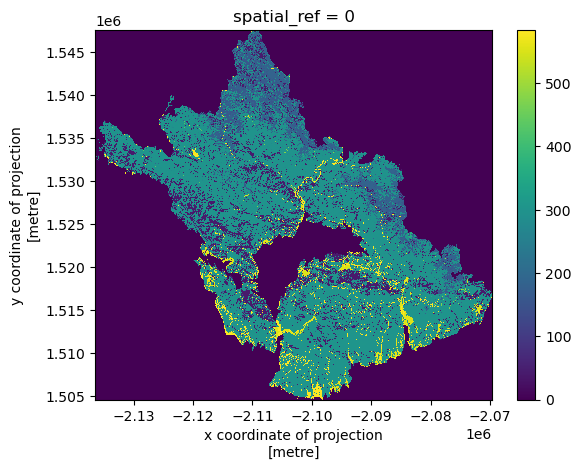

In [39]:
lulc_clip = (lulc.rio.clip_box(*thomas_fire_match.total_bounds)
             .rio.clip(thomas_fire_match.geometry))

lulc_clip.plot()

1.Use the numpy function np.unique() to get the number of pixels per class in lulc_clip. 

HINT: check the np.unique() documentation to see what the return_counts parameter does and read the last example.

In [48]:
values, counts = np.unique(lulc_clip, return_counts = True)

In [49]:
values

array([  0,  39,  40,  41,  42,  43,  45,  55, 159, 162, 165, 183, 277,
       278, 282, 296, 297, 300, 302, 303, 304, 305, 359, 360, 383, 385,
       432, 470, 472, 485, 489, 516, 539, 540, 547, 552, 553, 556, 557,
       558, 567, 568, 578, 579, 581, 582, 583, 584], dtype=uint16)

In [50]:
counts

array([1927870,    6856,     361,  133704,    3638,   23150,    2907,
          4974,    3727,   60203,    5102,   75925,     378,   11098,
            29,      98,   64072,   69700,  183963,  454489,   88504,
           799,     750,     684,      28,      90,     865,     262,
          1329,      54,      44,      27,     298,      24,      15,
            43,       7,   18996,    2181,     485,      13,      20,
            10,    1858,   40653,    3782,     829,      58])

In [60]:
d = {'code' : values,
     'number_of_pix' : counts
     }

pix_counts = pd.DataFrame(d)

In [61]:
pix_counts

,code,number_of_pix
0,0,1927870
1,39,6856
2,40,361
3,41,133704
4,42,3638
5,43,23150
6,45,2907
7,55,4974
8,159,3727
9,162,60203


In [65]:
classes = pd.merge(labels, pix_counts, on = "code")
classes.head()

,class_label,code,number_of_pix_x,number_of_pix_y
0,0,0,1927870,1927870
1,California Central Valley Mixed Oak Savanna,39,6856,6856
2,California Coastal Closed-Cone Conifer Forest ...,40,361,361
3,California Coastal Live Oak Woodland and Savanna,41,133704,133704
4,California Lower Montane Blue Oak-Foothill Pin...,42,3638,3638


In [92]:
developed = classes[classes['class_label'] =='Developed, Open Space']
number_of_pix_dev = developed['number_of_pix_x']
number_of_pix_dev

44    40653
Name: number_of_pix_x, dtype: int64

In [78]:
res = 30*30
area_dev = number_of_pix_dev*res
area_dev_km = area_dev/1000
area_dev_km

44    36587.7
Name: number_of_pix_x, dtype: float64

In [80]:
total_pixels = classes['number_of_pix_x'].sum()

In [81]:
total_pixels

3194952

In [86]:
classes['percentage'] = classes['number_of_pix_x']/total_pixels * 100

In [87]:
classes.head()

,class_label,code,number_of_pix_x,number_of_pix_y,percentage
0,0,0,1927870,1927870,60.341126
1,California Central Valley Mixed Oak Savanna,39,6856,6856,0.214589
2,California Coastal Closed-Cone Conifer Forest ...,40,361,361,0.011299
3,California Coastal Live Oak Woodland and Savanna,41,133704,133704,4.184852
4,California Lower Montane Blue Oak-Foothill Pin...,42,3638,3638,0.113867


In [88]:
plot = classes[classes['percentage'] > 1]

<Axes: xlabel='percentage'>

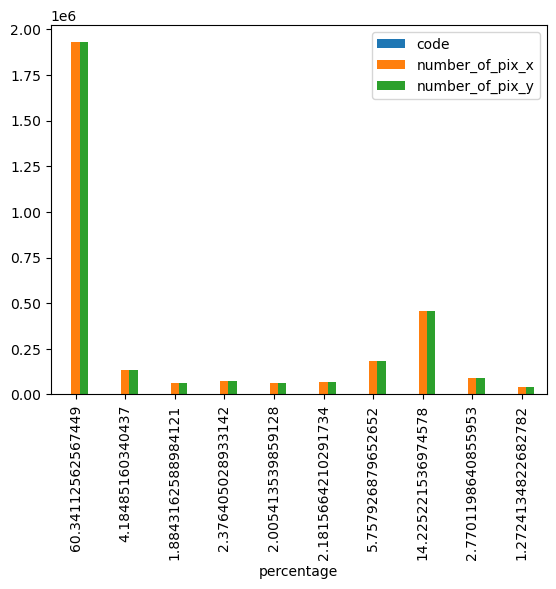

In [91]:
plot.plot(kind = 'bar',
          x = 'percentage')